##  This file contains info for the other schools students attend besides Siena College in the last **3** years

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import os
import sys
import xgboost as xgb
import shap
import altair as alt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import r2_score, auc, f1_score, explained_variance_score


import warnings
warnings.filterwarnings('ignore')

sys.path.insert(0, '../src/visualization/')
import visualize as vis

### Load college code converters and insert them into the data frame.

In [2]:
df = pd.read_csv('../data/processed/CriticalPath_Data_EM_Confidential_lessNoise.csv').drop(columns='Unnamed: 0')

_2017 = pd.read_csv('../data/raw/201730_Fresh_Not_Enrolled_College_Choice.csv').set_index("SARADAP_PIDM")
_2018 = pd.read_csv('../data/raw/201830_Fresh_Not_Enrolled_College_Choice.csv').set_index("SARADAP_PIDM")
_2019 = pd.read_csv('../data/raw/201930_Fresh_Not_Enrolled_College_Choice.csv').rename(columns={"PIDM":"SARADAP_PIDM"}).set_index("SARADAP_PIDM")

last_three_years_df = pd.concat([_2017,_2018,_2019])
mapper = last_three_years_df.to_dict()

df = df.drop(columns='College_chosen_by_non-matrics')
df['College_chosen_by_non-matrics'] = df['Unique_student_ID'].map(mapper['CollegeName'])

### Visualizations

In [3]:
college_by_major = df[['College_chosen_by_non-matrics','Major','Unique_student_ID']]
college_by_major = college_by_major[~college_by_major['College_chosen_by_non-matrics'].isnull()]

college_by_major = college_by_major.groupby(["College_chosen_by_non-matrics",
                                              "Major"]).count().rename(columns={"Unique_student_ID":"Num Students"})
college_by_major = college_by_major.reset_index()

### Breakdown of kids who choose UAlbany over Siena by Major

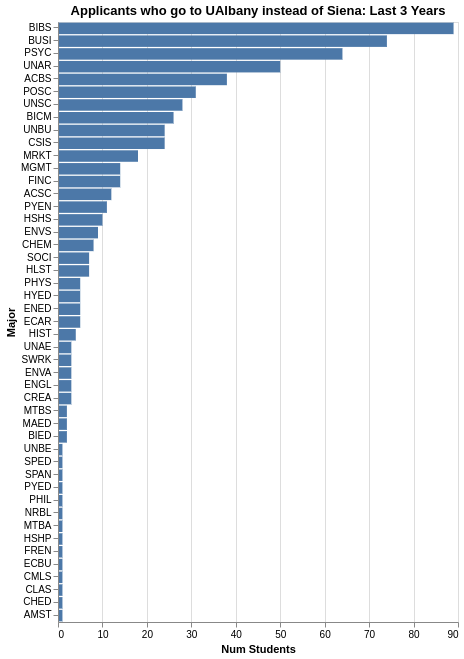

In [10]:
alt.Chart(college_by_major[college_by_major['College_chosen_by_non-matrics']=='SUNY UNIVERSITY AT ALBANY']).mark_bar().encode(
    x='Num Students:Q',
    y=alt.Y(
        'Major:O',
        sort = alt.EncodingSortField(
                field='Num Students',
                op = "sum",
                order = "descending"
        )
    )
).properties(height=600,width=400,title='Applicants who go to UAlbany instead of Siena: Last 3 Years')

### Kids who go to other schools by major.

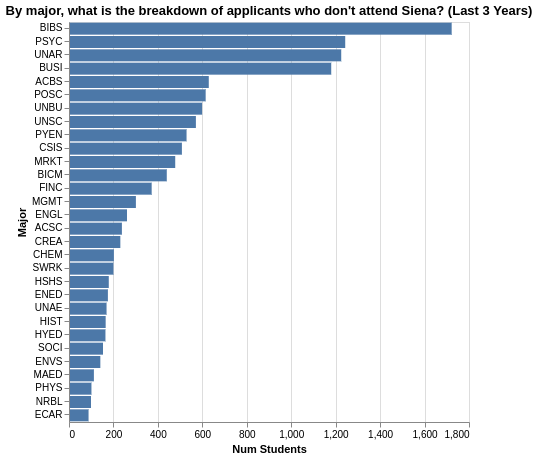

In [5]:
alt.Chart(college_by_major.groupby("Major").sum().reset_index(
).sort_values("Num Students",ascending=False).iloc[:30]).mark_bar().encode(
    x='Num Students:Q',
    y=alt.Y(
        'Major:O',
        sort = alt.EncodingSortField(
                field='Num Students',
                op = "sum",
                order = "descending"
        )
    )
).properties(height=400,width=400,title="By major, what is the breakdown of applicants who don't attend Siena? (Last 3 Years)")

### Breakdown of Collges applicants choose over Siena, by School of Science/Business/Liberal Arts

In [6]:
college_by_school = df[['College_chosen_by_non-matrics','CollegeCode','Unique_student_ID']]
college_by_school = college_by_school[~college_by_school['College_chosen_by_non-matrics'].isnull()]

college_by_school = college_by_school.groupby(["College_chosen_by_non-matrics",
                                              "CollegeCode"]).count().rename(columns={"Unique_student_ID":"Num Students"})
college_by_school = college_by_school.reset_index().rename(columns={"CollegeCode":"School"})
college_by_school['School'] = college_by_school['School'].map({"AD":"School of Art","BD":"School of Business","SD":"School of Science"})

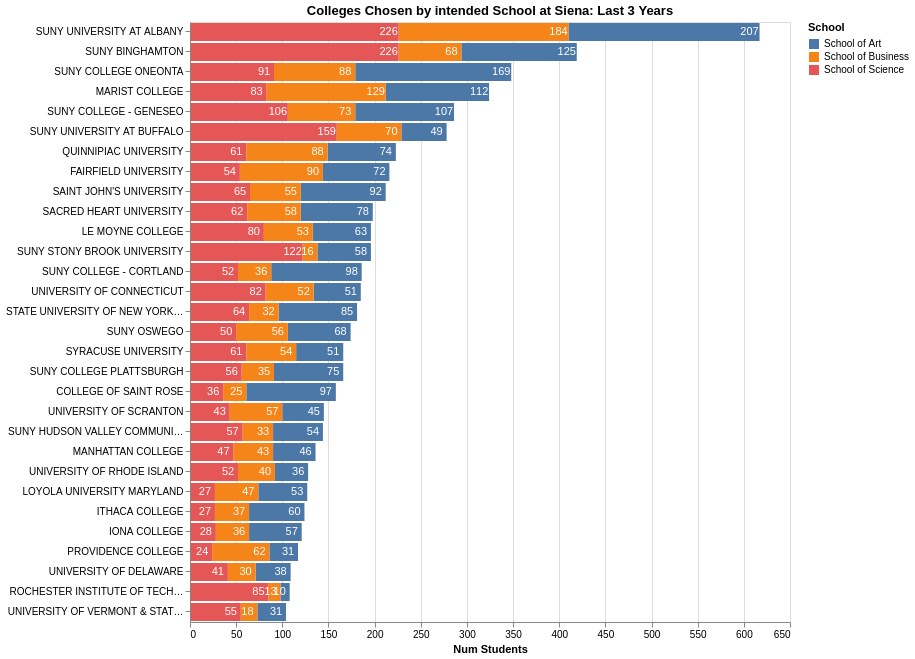

In [7]:
num_colleges = 30
height = 600
width = 600

top_choices = college_by_major.groupby("College_chosen_by_non-matrics").sum().sort_values("Num Students",
                                                        ascending=False).iloc[:num_colleges].index.values

bars = alt.Chart(college_by_school.set_index("College_chosen_by_non-matrics").loc[top_choices].reset_index()).mark_bar().encode(
    x=alt.X('Num Students:Q', stack='zero'),
    y=alt.Y('College_chosen_by_non-matrics:O',axis=alt.Axis(title=''),
           sort=alt.EncodingSortField(
            field="yield",  # The field to use for the sort
            op="sum",  # The operation to run on the field prior to sorting
            order="ascending"  # The order to sort in
        )),
    color=alt.Color('School')
).properties(height=height,width=width,title="Colleges Chosen by intended School at Siena: Last 3 Years")

text = alt.Chart(college_by_school.set_index("College_chosen_by_non-matrics").loc[top_choices].reset_index()).mark_text(
    dx=-10, dy=3, color='white').encode(
    x=alt.X('Num Students:Q', stack='zero'),
    y=alt.Y('College_chosen_by_non-matrics:O',sort=alt.EncodingSortField(
            field="yield",  # The field to use for the sort
            op="sum",  # The operation to run on the field prior to sorting
            order="ascending"  # The order to sort in
        )),
    detail='School:O',
    text=alt.Text('Num Students:Q', format='.0f')
).properties(height=height,width=width)

bars + text

### Where do Undeclared Liberal Arts Majors Go??

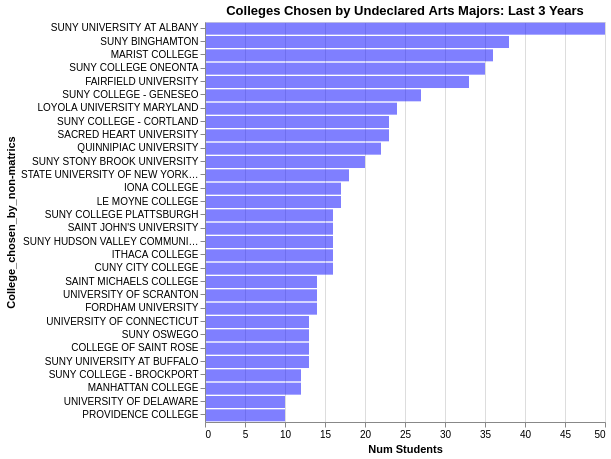

In [8]:
alt.Chart(college_by_major[college_by_major['Major']=='UNAR'].groupby(
    "College_chosen_by_non-matrics").sum().reset_index(
).sort_values("Num Students",ascending=False).iloc[:30]).mark_bar().encode(
    x='Num Students:Q',
    y=alt.Y(
        'College_chosen_by_non-matrics:O',
        sort = alt.EncodingSortField(
                field='Num Students',
                op = "sum",
                order = "descending"
        )
    )
).properties(height=400,width=400,title='Colleges Chosen by Undeclared Arts Majors: Last 3 Years').configure_mark(
   opacity=0.5,color='blue')